# COGS 108 - Yelp Ratings and Inspection Scores

# Overview

This project seeks to explore the relationship between Yelp ratings and inspection scores. Inspection scores have been criticized before as "misleading," as many minor points can be deducted. In the end, I find that the difference between distributions of inspection scores amongst different Yelp ratings is inconsequential, and that there is no relationship between Yelp ratings and health inspection scores.

# Name & GitHub

- Name: Jerlene Hsueh
- GitHub Username: striyo
- PID: A15522713

# Research Question

Do Yelp ratings have a relationship with the distribution of average health inspection scores?

## Background and Prior Work

Yelp is a website commonly used to look for restaurant recommendations. Users are able to rate the restaurant out of 5 "stars," and the ratings are averaged together and displayed (alongside reviews) for other users to make their own judgements about whether or not they would wish to visit the restaurant. Yelp has been noted previously to have a substantial impact on the amount of traffic and business that a restaurant receives, making it a high-profile website in so-called "foodie" culture.

Starting in 2018 (1), Yelp began displaying the health inspection scores of restaurants on their review pages. This garnered a fair bit of controversy: not only were the methods that Yelp used to convert local government inspection procedures to a standardized scale of 1 - 100 concerningly opaque, restauranteurs objected that the display was incredibly harmful and misleading as it could take long periods of time to properly update the restaurant's grade to its rightful status. Restaurants are concerned that this display would have a harmful effect on their ratings, and consequentially their business. 

After launching this program in San Francisco, Yelp found that posting a low health inspection score could decrease purchase intentions for a restaurant by 12%(2). It is safe to say that if the average customer sees that a restaurant performed poorly on a government health inspection test, they would be reluctant to engage further out of perceived health risks. This begs the question: do private, unposted health inspection scores, as they stand, have any relationship with a user's perceived quality of the restaurant?


References (include links):
- 1)https://www.washingtonpost.com/news/voraciously/wp/2018/07/24/yelp-adds-health-inspection-scores-for-restaurants-and-restaurateurs-are-not-happy/
- 2)https://www.dailynews.com/2020/01/22/yelps-la-county-restaurant-business-pages-will-now-include-health-score-alerts/

# Hypothesis


I hypothesize that health inspection scores have no relationship with Yelp ratings, because I believe that many health inspections infractions are relatively trivial, and have no significant impact on a customer's perceived quality of the restaurant.

# Dataset(s)

- Dataset Name: yelp.csv
- Link to the dataset: Given (individual proj)
- Number of observations: 3688

Contains information about the restaurant, its Yelp rating, its price category, and the food category that it fits into. It also contains other identifiers, such as phone numbers and addresses.

- Dataset Name: inspections.csv
- Link to the dataset: Given (individual proj)
- Number of observations: 18466

Contains information about each health inspection on a restaurant that was conducted by a health inspector. It contains variables such as the date of the inspection, restaurant identifiers, and the inspection's overall score, as well as any comments.


I plan to combine these two datasets by utilizing the shared phone numbers between the two.

# Setup

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

First, let's take a look at what we're working with.

In [2]:
inspections = pd.read_csv('inspections.csv')
yelp = pd.read_csv('yelp.csv')

In [3]:
inspections.shape

(18466, 36)

In [4]:
inspections.columns

Index(['hsisid', 'date', 'name', 'address1', 'address2', 'city', 'state',
       'postalcode', 'phonenumber', 'restaurantopendate',
       'days_from_open_date', 'facilitytype', 'x', 'y', 'geocodestatus', 'zip',
       'type', 'description', 'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'score', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical'],
      dtype='object')

In [5]:
yelp.columns

Index(['id', 'name', 'is_closed', 'rating', 'review_count', 'address1',
       'zip_code', 'latitude', 'longitude', 'price', 'phone', 'hotdogs',
       'sandwiches', 'pizza', 'tradamerican', 'burgers', 'mexican', 'grocery',
       'breakfast_brunch', 'coffee', 'chinese', 'italian', 'newamerican',
       'chicken_wings', 'delis', 'bars', 'salad', 'seafood', 'bbq', 'bakeries',
       'sushi'],
      dtype='object')

That's a lot of columns, but we're mostly interested in the phone number columns (for merging and cleaning) as well as scores and rating (for analysis). Let's clean it up. 

In [6]:
rows_to_drop = inspections[inspections.phonenumber.isnull()]
rows_to_drop.head()

,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
3,4092016122,2012-09-21T00:00:00Z,Panera Bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
19,4092300210,2012-09-25T00:00:00Z,International Foods,2215 New Hope Church Rd,NaN,raleigh,NC,27604-1600,NaN,2002-09-19T00:00:00Z,...,6,NaN,NaN,NaN,NaN,4.8,9.4,4.092014e+09,4.092014e+09,0
45,4092300175,2012-09-27T00:00:00Z,Food Lion #1496 Meat Market,1777 W Williams ST,NaN,apex,NC,27502,NaN,2000-07-01T00:00:00Z,...,4,NaN,NaN,NaN,NaN,5.0,5.4,4.092110e+09,4.092050e+09,1
87,4092110490,2012-10-03T00:00:00Z,HOLLY GROVE MIDDLE SCHOOL CAFETERIA,1401 AVENT FERRY RD,NaN,holly springs,NC,27540,NaN,2010-03-30T00:00:00Z,...,2,NaN,NaN,NaN,NaN,7.4,7.6,4.092014e+09,4.092016e+09,1
102,4092300155,2012-10-04T00:00:00Z,Food Lion #586 Meat Market,3416 POOLE RD,NaN,raleigh,NC,27610-2918,NaN,2000-07-01T00:00:00Z,...,5,NaN,NaN,NaN,NaN,3.8,7.8,4.092014e+09,4.092016e+09,1


In [7]:
#dropped inspections with missing phone numbers and score
inspections = inspections.dropna(axis = 0, subset = ['phonenumber', 'score'])
inspections.shape

(17965, 36)

In [8]:
#clean up phone numbers on inspections
def standardize_phone(string):
    string = string.lower()
    string = string.strip()
    string = string.replace('(','').replace(')','')
    string = string.replace('-','')
    string = string.replace(" ", "")
    
    if 'ext' in string:
        string = string[:string.find("ext")]
    return '1' + string

In [9]:
inspections['phonenumber'] = inspections['phonenumber'].apply(standardize_phone)

Now that the 'phonenumber' column in the inspections dataframe is properly standardized so that it has the same format as the phone numbers in the yelp dataframe, we can now go ahead and merge the two dataframes together on the phone columns. 

In [11]:
#rename
inspections = inspections.rename(columns={"phonenumber": "phone"})
#merge
df = pd.merge(inspections, yelp, on='phone')

As we can see below, we've successfully combined the data between inspections and yelp.

In [34]:
df.columns

Index(['hsisid', 'date', 'name_x', 'address1_x', 'address2', 'city', 'state',
       'postalcode', 'phone', 'restaurantopendate', 'days_from_open_date',
       'facilitytype', 'x', 'y', 'geocodestatus', 'zip', 'type', 'description',
       'inspectedby', 'inspection_num', 'inspector_id',
       'previous_inspection_date', 'days_since_previous_inspection',
       'previous_inspection_by_same_inspector', 'score', 'num_critical',
       'num_non_critical', 'num_critical_previous',
       'num_non_critical_previous', 'num_critical_mean_previous',
       'num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match',
       'critical', 'id', 'name_y', 'is_closed', 'rating', 'review_count',
       'address1_y', 'zip_code', 'latitude', 'longitude', 'price', 'hotdogs',
       'sandwiches', 'pizza', 'tradamerican', 'burgers', 'mexican', 'grocery',
       'breakfast_brunch', 'coffee', 'chinese', 'italian', 'newamerican',
       

Let's also check to see if there's any missing Yelp ratings and remove them.

In [13]:
df = df.dropna(axis = 0, subset = ['rating'])

# Data Analysis & Results

Let's take a look at the data and see some of the stats for the 'score' and 'rating' variables respectively.

In [14]:
score_mean = df.groupby('hsisid')['score'].mean()
score_mean

hsisid
4092010018    94.333333
4092010024    94.772727
4092010037    96.400000
4092010046    96.318182
4092010065    96.750000
                ...    
4092300263    94.000000
4092300267    98.250000
4092300270    98.000000
4092300271    92.500000
4092300274    99.500000
Name: score, Length: 2003, dtype: float64

In [15]:
rating = df.groupby('hsisid')['rating'].mean()
rating

hsisid
4092010018    4.0
4092010024    2.0
4092010037    4.5
4092010046    3.0
4092010065    4.0
             ... 
4092300263    5.0
4092300267    4.0
4092300270    4.5
4092300271    4.5
4092300274    4.0
Name: rating, Length: 2003, dtype: float64

I made a new dataframe containing the rating and mean score for each restaurant (identified through its hsisid).

In [16]:
test = pd.concat([score_mean, rating], axis = 1)
test.head()

,score,rating
hsisid,,
4092010018,94.333333,4.0
4092010024,94.772727,2.0
4092010037,96.400000,4.5
4092010046,96.318182,3.0
4092010065,96.750000,4.0


We plot the distributions of each variable.

Text(0.5, 0, 'score')

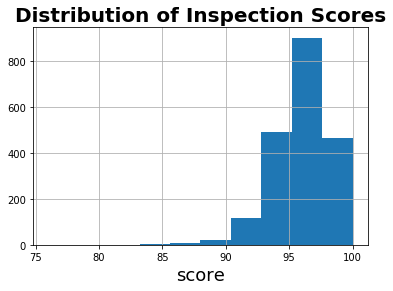

In [17]:
scoreHist = test['score'].hist()
scoreHist.set_title('Distribution of Inspection Scores',fontweight="bold", size=20)
scoreHist.set_xlabel("score", fontsize = 18)


We see that most average inspection scores are actually fairly good. The mean is roughly around 96, which corresponds to an 'A' rating. It doesn't look normal, though.

In [18]:
test['score'].mean()

95.96209292316381

Text(0.5, 0, 'rating')

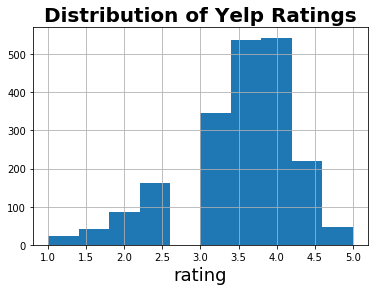

In [19]:
ratingHist = test['rating'].hist()
ratingHist.set_title('Distribution of Yelp Ratings', fontweight="bold", size = 20)
ratingHist.set_xlabel("rating", fontsize = 18)

In [35]:
test['rating'].mean()

3.4780329505741387

Yelp ratings have a mean roughly around 3.5. There aren't many ratings that are above 4 stars, and the distribution is visibly left skewed.

Unfortunately, these distributions don't look very normal. We investigate further:

In [20]:
h_rating = test['rating'].values
h_score = test['score'].values

In [21]:
st_rating = normaltest(h_rating)[0]
p_rating = normaltest(h_rating)[1]
st_score = normaltest(h_score)[0]
p_score = normaltest(h_score)[1]
print(st_rating)
print(p_rating)
print(st_score)
print(p_score)

150.82968252917888
1.7690926786330658e-33
577.6581092265102
3.657087640424084e-126


...And our suspicions are confirmed. With an alpha level of 0.01, there's a significant difference from a normal distribution. However, we can still investigate individual distributions within each discrete value of Yelp ratings.

Text(0, 0.5, 'score')

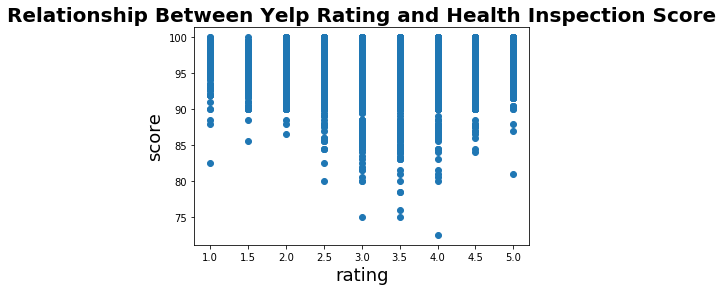

In [22]:
plt.scatter(df['rating'], df['score'])
plt.title('Relationship Between Yelp Rating and Health Inspection Score', fontweight="bold", size = 20)
plt.xlabel('rating', size = 18)
plt.ylabel('score', size = 18)

Here, we see the scatterplot generated by plotting Yelp ratings on the x-axis and inspection scores on the y-axis. These distributions look fairly uniform, and suggest that there isn't much variation when it comes to the distribution of health inspection scores related to Yelp ratings. We investigate further.

In [23]:
h_five = test[test['rating'] == 5.0]['score'].values
h_fourf = test[test['rating']== 4.5]['score'].values
h_four = test[test['rating'] == 4.0]['score'].values
h_threef = test[test['rating'] == 3.5]['score'].values
h_three = test[test['rating'] == 3.0]['score'].values
h_twof = test[test['rating'] == 2.5]['score'].values
h_two = test[test['rating'] == 2.0]['score'].values
h_onef = test[test['rating'] == 1.5]['score'].values
h_one = test[test['rating'] == 1.0]['score'].values

Okay, let's look and check to see if these values have normal distributions.

In [24]:
normaltest(h_five)

NormaltestResult(statistic=6.045414477660174, pvalue=0.04866928048296503)

In [25]:
normaltest(h_fourf)

NormaltestResult(statistic=19.8300135856724, pvalue=4.942734260634337e-05)

In [26]:
normaltest(h_four)

NormaltestResult(statistic=36.022195863877826, pvalue=1.5061892899444217e-08)

In [27]:
normaltest(h_threef)

NormaltestResult(statistic=270.6396338342661, pvalue=1.7035317048094411e-59)

In [28]:
normaltest(h_three)

NormaltestResult(statistic=65.7768145576472, pvalue=5.208902161959703e-15)

In [29]:
normaltest(h_twof)

NormaltestResult(statistic=4.263760726936458, pvalue=0.11861404650524357)

In [30]:
normaltest(h_two)

NormaltestResult(statistic=29.979104212394063, pvalue=3.0911510967534545e-07)

In [31]:
normaltest(h_onef)

NormaltestResult(statistic=1.8340908649663303, pvalue=0.399698233642346)

In [32]:
normaltest(h_one)

NormaltestResult(statistic=2.0619590421351623, pvalue=0.3566574359413113)

Some of the above distributions are normal, while others aren't. We conduct a one way ANOVA test on the distributions that *are* normal, in order to check to see if there is a significant difference between the means of these groups.

In [33]:
stats.f_oneway(h_five, h_twof, h_onef, h_one)

F_onewayResult(statistic=3.1521227424049365, pvalue=0.02543378899927648)

With a p-value of ~0.02, which is greater than alpha = 0.01, we fail to reject the null hypothesis. There is not a significant difference in between the mean of the Yelp rating distributions. 

# Ethics & Privacy

Consent is not too large of an issue, as restaurant health inspection scores and Yelp ratings are both public data. The main ethics issue concerning this project is regarding the human bias in collection of data, as well as the impacts of unfair health inspections towards certain restaurants—for instance, it is possible that inspectors are biased towards certain restaurants with certain Yelp ratings, and unfairly skew the data. We must also be conscious that Yelp ratings are not an absolute judge of quality, and that at the end of the day, restaurant quality can be entirely subjective. Although we may find that inspection scores have at very best a tenuous relationship with Yelp ratings, this is not to say that inspection scores are not useful metrics for determining quality.

For the sake of privacy, phone numbers have been carefully omitted from the writeup of this project. They were, however, used in order to match restaurants and merge between two different datasets. 

# Conclusion & Discussion

Firstly, we should remember that this project only wished to evaluate the relationship between the available data of health inspection scores and Yelp ratings. Both are a product of human evaluation, and, as such, are prone to human bias. As noted above in ethics, the fact that there's no perceived difference in quality between different inspection scores doesn't mean that health inspections are absolutely useless. It is possible that Yelp ratings are mostly focused on taste and flavor, and are not as concerned as a inspector is on whether or not an employee has properly labelled a bottle of hand sanitizer in the kitchen. We also did not account for the number of Yelp reviews, which casts doubt to the true Yelp rating of the restaurants. Lower review counts suggest a more unreliable rating, and may have negatively influenced the accuracy of this project.

Secondly, note that this project did not include some of the Yelp rating distributions in the ANOVA test. Although this ideally would not happen, I believe this to be forgiveable because we have included the distributions of a Yelp rating of 'one' and 'five,' which is the biggest rating difference possible. If there was truly a significant result to be found, then it would have surely been detected through the ANOVA test of the 'one' and 'five' distribution. 

Seeing that even restaurants with a one star rating have roughly the same distribution in inspection scores as restaurants with a five star rating suggests that the proficiency of a restaurant in following local health ordinances has no correlation with the flavor and taste that a customer experiences. This further seems to suggest that inspectors are not swayed or biased by Yelp ratings, which supports my wish that restaurant health inspections be an unbiased process that does not take into account the popularity of the restaurant on a website. There are still other factors to be explored, such as whether a restaurant with a wealthier clientele tends to recieve better scores, but this is the conclusion when it comes to Yelp ratings.
